### Методы распознавания текста (OCR) на изображениях и PDF-файлах анализа крови. 

In [1]:
#библиотеки
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import json
import cv2
from pdf2image import convert_from_path
import fitz


In [2]:
# Указываем путь к tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [7]:
image_path = 'C:\\Users\\admin\\Desktop\\DS\\git\\mipt\\hakaton_3 sem\\OAK\\oak'
json_dir= 'C:\\Users\\admin\\Desktop\\DS\\git\\mipt\\hakaton_3 sem\\jsons_file'
txt_from_img_dir = 'C:\\Users\\admin\\Desktop\\DS\\git\\mipt\\hakaton_3 sem\\txt_from_img_dir'

## Предобработка изображений с помощью библиотеки Open CV.

In [8]:
def adapt_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)


def preprocess_image(image_path):
    """
    Предобработка изображения для улучшения качества текста.
    """
    # Чтение изображения
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Увеличение разрешения
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Улучшение контраста с помощью CLAHE
    img = adapt_contrast(img)

    # Удаление шума с помощью Non-Local Means
    img = cv2.fastNlMeansDenoising(img, None, 30, 7, 21)

    # Применение адаптивного порога
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Использование морфологических операций
    kernel = np.ones((3, 3), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    # Использование Canny для выделения краёв
    edges = cv2.Canny(img, 50, 150)
    img = cv2.bitwise_or(img, edges)

    # Сохраняем результат
    temp_img_path = "temp_processed_image.png"
    cv2.imwrite(temp_img_path, img)

    return temp_img_path


### Преобразование в .txt

In [15]:
def process_image_into_txt(image_path, txt_from_img_dir):
    """
    Извлечение текста из изображений с сохранением координат слов в .txt файлы.
    """
    os.makedirs(txt_from_img_dir, exist_ok=True)

    for file_name in os.listdir(image_path):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Проверяем допустимые форматы изображений
            file_path = os.path.join(image_path, file_name)
            
            try:
                # Загружаем изображение
                image = Image.open(file_path)

                # Используем Tesseract для получения текста и координат
                data = pytesseract.image_to_data(
                    image,
                    lang='rus+eng',
                    #config='--psm 4',
                    config = '--psm 4 --oem 3 --dpi 600',
                    output_type=pytesseract.Output.DICT
                )

                # Создаём файл для сохранения
                output_file_name = f"{os.path.splitext(file_name)[0]}_words.txt"
                output_path = os.path.join(txt_from_img_dir, output_file_name)

                with open(output_path, 'w', encoding='utf-8') as output_file:
                    for i in range(len(data['text'])):
                        text = data['text'][i]
                        conf = int(data['conf'][i])
                        x, y = int(data['left'][i]), int(data['top'][i])
                        width = int(data['width'][i])
                        height = int(data['height'][i])

                        # Пропускаем пустые или плохо распознанные слова
                        if conf <= 0 or not text.strip():
                            continue

                        # Сохраняем в формате: <text> <x> <y> <width> <height>
                        output_file.write(f"{text} {x} {y} {width} {height}\n")

                # Закрываем обработанное изображение
                image.close()

            except Exception as e:
                print(f"Ошибка при обработке файла {file_name}: {e}")

process_image_into_txt(image_path, txt_from_img_dir)

In [6]:
def process_pdf_into_txt(image_path, txt_from_img_dir):
    """
    Обработка всех PDF в директории для извлечения текста с координатами слов в формате .txt.
    """
    os.makedirs(txt_from_img_dir, exist_ok=True)

    # Итерация по всем файлам в директории
    for file_name in os.listdir(image_path):
        if file_name.endswith('.pdf'):  # Проверяем, является ли файл PDF
            file_path = os.path.join(image_path, file_name)

            try:
                # Открытие PDF файла
                doc = fitz.open(file_path)
                output_file_name = f"{os.path.splitext(file_name)[0]}_words.txt"
                output_path = os.path.join(txt_from_img_dir, output_file_name)

                with open(output_path, 'w', encoding='utf-8') as output_file:
                    # Проходим по каждой странице
                    for page_num in range(doc.page_count):
                        page = doc.load_page(page_num)  # Загружаем страницу
                        blocks = page.get_text("dict")["blocks"]  # Извлекаем текст в виде блоков

                        # Проходим по каждому блоку на странице
                        for block in blocks:
                            if block["type"] == 0:  # Только текстовые блоки
                                for line in block["lines"]:
                                    for span in line["spans"]:
                                        text = span["text"]
                                        x, y = span["bbox"][0], span["bbox"][1]
                                        width = span["bbox"][2] - span["bbox"][0]
                                        height = span["bbox"][3] - span["bbox"][1]

                                        # Сохраняем в формате: <text> <x> <y> <width> <height>
                                        output_file.write(f"{text} {x} {y} {width} {height}\n")

                print(f"Успешно обработан файл: {file_name}")

            except Exception as e:
                print(f"Ошибка при обработке файла {file_name}: {e}")
process_pdf_into_txt(image_path, txt_from_img_dir)

Успешно обработан файл: Жен(11лет).pdf
Успешно обработан файл: Жен(12лет).pdf
Успешно обработан файл: Жен(44).pdf
Успешно обработан файл: Муж(21 год) (1).pdf
Успешно обработан файл: Муж(21 год) (2).pdf


## Преобразование в JSON

In [66]:
import os
import fitz  # PyMuPDF
import json

def process_pdf_directory(image_path, json_dir):
    """
    Обработка всех PDF в директории для извлечения текста с координатами слов в формате JSON.
    """
    os.makedirs(json_dir, exist_ok=True)

    # Итерация по всем файлам в директории
    for file_name in os.listdir(image_path):
        if file_name.endswith('.pdf'):  # Проверяем, является ли файл PDF
            file_path = os.path.join(image_path, file_name)

            try:
                # Открытие PDF файла
                doc = fitz.open(file_path)
                words_with_coordinates = []

                # Проходим по каждой странице
                for page_num in range(doc.page_count):
                    page = doc.load_page(page_num)  # Загружаем страницу
                    blocks = page.get_text("dict")["blocks"]  # Извлекаем текст в виде блоков

                    # Проходим по каждому блоку на странице
                    for block in blocks:
                        if block["type"] == 0:  # Только текстовые блоки
                            for line in block["lines"]:
                                for span in line["spans"]:
                                    word_data = {
                                        "text": span["text"],
                                        "x": span["bbox"][0],
                                        "y": span["bbox"][1],
                                        "width": span["bbox"][2] - span["bbox"][0],
                                        "height": span["bbox"][3] - span["bbox"][1]
                                    }
                                    words_with_coordinates.append(word_data)

                # Сохранение в JSON
                output_file_name = f"{os.path.splitext(file_name)[0]}_words.json"
                output_path = os.path.join(json_dir, output_file_name)

                with open(output_path, 'w', encoding='utf-8') as output_file:
                    json.dump(words_with_coordinates, output_file, ensure_ascii=False, indent=4)
                
                print(f"Успешно обработан файл: {file_name}")

            except Exception as e:
                print(f"Ошибка при обработке файла {file_name}: {e}")

process_pdf_directory(image_path, json_dir)



Успешно обработан файл: Жен(11лет).pdf
Успешно обработан файл: Жен(12лет).pdf
Успешно обработан файл: Жен(44).pdf
Успешно обработан файл: Муж(21 год) (1).pdf
Успешно обработан файл: Муж(21 год) (2).pdf


In [103]:
def process_image_directory(image_path, json_dir):
    """
    Извлечение текста из изображений с сохранением координат слов в JSON.
    """
    os.makedirs(json_dir, exist_ok=True)

    for file_name in os.listdir(image_path):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Проверяем допустимые форматы изображений
            file_path = os.path.join(image_path, file_name)
            
            try:
                # Загружаем изображение
                image = Image.open(file_path)

                # Используем Tesseract для получения текста и координат
                data = pytesseract.image_to_data(
                    image,
                    lang='rus+eng',
                    config='--psm 11',
                    output_type=pytesseract.Output.DICT
                )

                # Структура для хранения текста и координат
                words_with_coordinates = []

                for i in range(len(data['text'])):
                    text = data['text'][i]
                    conf = int(data['conf'][i])
                    x, y = int(data['left'][i]), int(data['top'][i])
                    width = int(data['width'][i])
                    height = int(data['height'][i])

                    # Пропускаем пустые или плохо распознанные слова
                    if conf <= 0 or not text.strip():
                        continue

                    # Сохраняем текст и его координаты
                    words_with_coordinates.append({
                        'text': text,
                        'x': x,
                        'y': y,
                        'width': width,
                        'height': height
                    })

                # Сохранение в файл JSON
                output_file_name = f"{os.path.splitext(file_name)[0]}_words.json"
                output_path = os.path.join(json_dir, output_file_name)
                with open(output_path, 'w', encoding='utf-8') as output_file:
                    json.dump(words_with_coordinates, output_file, ensure_ascii=False, indent=4)

                # Закрываем обработанное изображение
                image.close()

            except Exception as e:
                print(f"Ошибка при обработке файла {file_name}: {e}")
process_image_directory(image_path, json_dir)


In [ ]:
# пример полученного файла

json_file_image_path = 'C:\\Users\\admin\\Desktop\\DS\\git\\mipt\\hakaton_3 sem\\jsons_file\\Жен(11лет)_words.json'
# чтение JSON файла
with open(json_file_image_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Преобразование в DataFrame
df = pd.DataFrame(data)

# Показ первых нескольких строк
print(df.head())


                                   text           x           y       width  \
0                      Дата: 04.08.2023   33.302753   28.589115   86.172817   
1           Полис ОМС: 5094789784001053   33.302753   49.601158  160.146465   
2                            КДЛ ТГБ ПО  385.104370   70.742470   72.108124   
3   КЛИНИКО-ДИАГНОСТИЧЕСКАЯ ЛАБОРАТОРИЯ  334.675476   84.849091  173.139465   
4  РЕЗУЛЬТАТЫ ЛАБОРАТОРНЫХ ИССЛЕДОВАНИЙ  222.411133  101.575478  397.469971   

      height  
0  11.181408  
1  11.181408  
2  13.277924  
3   8.386055  
4  16.772110  


In [104]:
# пример полученного файла

json_file_image_path2 = 'C:\\Users\\admin\\Desktop\\DS\\git\\mipt\\hakaton_3 sem\\jsons_file\\Жен-73_words.json'
# Чтение JSON файла
with open(json_file_image_path2, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Преобразование в DataFrame
df = pd.DataFrame(data)

# Показ первых нескольких строк
print(df.head())

      text    x   y  width  height
0    Bpaw:  514   5     27      14
1  Клешнев  548   6     70      11
2       OB  605   0     16      26
3       лн  574  37     35       9
4   Pop-we  624  37     35      15


In [105]:
json_file_path2 = 'C:\\Users\\admin\\Desktop\\DS\\git\\mipt\\hakaton_3 sem\\jsons_file\\Жен-73_words.json'
with open(json_file_path2, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Загрузка исходного изображения
image_path = 'C:\\Users\\admin\\Desktop\\DS\\git\\mipt\\hakaton_3 sem\\OAK\\oak\\Жен-73.png'
image = Image.open(image_path)

# Создание объекта на изображении
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# Наложение текста с координатами (x, y)
for word_info in data:
    text = word_info['text']
    x, y = word_info['x'], word_info['y']
    
    # Рисуем прямоугольник, чтобы увидеть границы каждого слова
    draw.rectangle([x, y, x + word_info['width'], y + word_info['height']], outline="red", width=2)
    
    # Рисуем текст
    draw.text((x, y), text, fill="black", font=font)

# демонстрация
image.show()
image.save('output_image_oak.png')

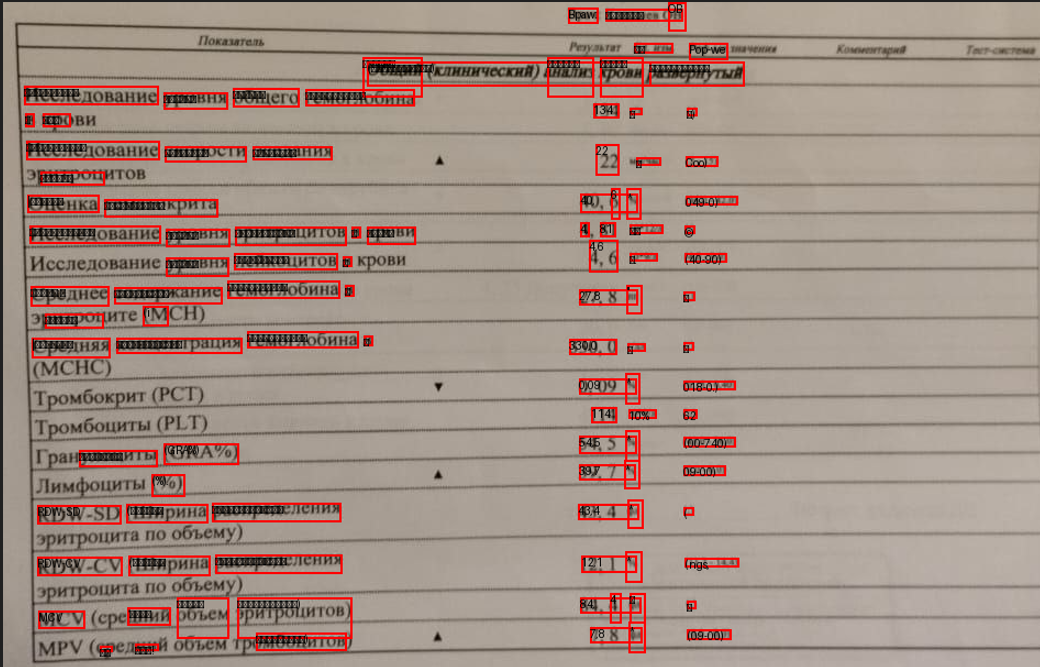